# Drop Zone Detection

**About the notebook**
This notebook is meant as a mockup of using the ultralytics/yolov5 model for drone object detection. The aim is to position the "drop zone" in the center of the screen directly below the camera. The program gives directions on how to get to the center of the screen. The thought of this is that you could steer the drone to the desired spot then drop the payload.

# Step 1: Get Data

1. take pictures with camera
2. use labelImg to label all images
3. create images and labels folder in /data
4. create yaml file in /yolov5 for the model

In [5]:
# create images folder from zip file
import os

if not os.path.exists("data_v2/images"):
    import zipfile as zf
    files = zf.ZipFile("drop_zone_dataset_1.zip")
    files.extractall("data_v2")
    files.close()

# for some reason this extracts as Drop zone images.  rename to data/Drop zone images to data/images

# Step 2: Train the model
**Errors I got while training**

* got error saying to clear cache file in /data -> solved by clearing cache file
* got error saying class name 15 doesn't match to 0. When labelImg exports, it exports like 15 additional classes.
    * https://github.com/heartexlabs/labelImg/issues/624
    * Solution is to go into cloned labelImg repo and remove everything in predefined_classes.txt

In [4]:
# !cd yolov5 && python train.py --img 640 --batch 16 --epochs 100 --data custom_dataset_v2.yaml --weights yolov5s.pt --workers 2

**Things I noticed while training**

* increasing --img will increase the time per epoch
* increasing --img from 300 to 640 allowed the model to detect big images (moving the camera close to the drop zone)

# Step 3: Get Model instance


In [1]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', "./yolov5/runs/train/exp/weights/best.pt")
model

Using cache found in C:\Users\holla/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2022-11-18 Python-3.10.8 torch-1.13.0 CUDA:0 (NVIDIA GeForce GTX 1060 with Max-Q Design, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

# Step 4: Use Open CV to evaluate the model


results.shape (1080, 1920, 3)
center_x 960 center_y 540
results.xyxy sorted:
           xmin        ymin         xmax        ymax  confidence  class   name
0  1281.734497  500.008057  1394.200439  594.580933    0.876774      0  zone1
highest confidence 0.876774251461029
row with highest result: 0
move to the left
on target


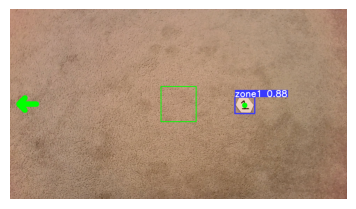

In [5]:
import cv2
import glob
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline

# Get All Image Paths
all_img_paths = glob.glob("data_v2/images/*.jpg")

plt.figure(figsize=(20,10))
for i in range(1):
    # Pick Random Path
    random_path = random.choice(all_img_paths)
#     random_path = "data_v2/multiple-zones-test-img.jpg" # This image proves results_xyxy sorted with highest confidence first (confidence descending)
    plt.subplot(2,4,i+1) # setup subplot
    img = cv2.imread(random_path)
    
    # Get Results from Model
    results = model(img)
    print("results.shape",img.shape)
    
    # Show Image
    show_img = cv2.cvtColor(np.squeeze(results.render()), cv2.COLOR_BGR2RGB)
#     show_img = np.squeeze(results.render())
    
    # Screen dimensions
    height=img.shape[0]
    width=img.shape[1]
    
    # Screen Center
    screen_center_x = width /2
    screen_center_y = height /2
    screen_center_x, screen_center_y = int(screen_center_x), int(screen_center_y)
    print("center_x", screen_center_x, "center_y", screen_center_y)
    
    if not results.pandas().xyxy[0].empty:
        # Sort Results
        results_xyxy = results.pandas().xyxy[0].sort_values(by=["confidence"], ascending=False) # row 0 has highest confidence
        print("results.xyxy sorted:\n", results_xyxy)
        print("highest confidence", results.pandas().xyxy[0]["confidence"].max())
        print("row with highest result:", results_xyxy["confidence"].idxmax())
        highest_confidence_row = results_xyxy.iloc[0]
    
        # Bounding Box Data
        xmin = int(highest_confidence_row["xmin"])
        xmax = int(highest_confidence_row["xmax"])
        ymin = int(highest_confidence_row["ymin"])
        ymax = int(highest_confidence_row["ymax"])
        center_x = (xmin + xmax)/2
        center_y = (ymin + ymax)/2
        center_x, center_y = int(center_x), int(center_y)
        
        # Variables for Text
        text = "Need to move up"
        coordinates = (100,height-100)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 4
        color = (255,0,0)
        thickness = 10

        if (xmax-xmin) * (ymax-ymin) > 200*200:
            show_img = cv2.putText(show_img, text, coordinates, font, fontScale, color, thickness, cv2.LINE_AA)
            print("need to move up")
        else:
            # Display Rectangles
            if (xmin < screen_center_x - 100):
                cv2.arrowedLine(show_img, (width-150, screen_center_y), (width-50, screen_center_y), (0, 255, 0), 30, tipLength = 0.5)
                print("move to the right")
            elif (xmax > screen_center_x+100):
                cv2.arrowedLine(show_img, (150, screen_center_y), (50, screen_center_y), (0, 255, 0), 30, tipLength = 0.5)
                print("move to the left")
            else:
                cv2.circle(show_img, (center_x, center_y), 15, (0, 255, 0), -1)
                print("on target")

            if (ymin < screen_center_y - 100):
                cv2.arrowedLine(show_img, (screen_center_x, height-150), (screen_center_x, height-50), (0, 255, 0), 30, tipLength = 0.5)
                print("move down")
            elif (ymax > screen_center_y+100):
                cv2.arrowedLine(show_img, (screen_center_x, 150), (screen_center_x, 50), (0, 255, 0), 30, tipLength = 0.5)
                print("move up")
            else:
                cv2.circle(show_img, (center_x, center_y), 15, (0, 255, 0), -1)
                print("on target")
    
    # Display target box rectangle
    cv2.rectangle(show_img, (screen_center_x-100, screen_center_y-100), (screen_center_x+100, screen_center_y+100), (0, 255, 0), 3)
    
    # Display middle of detected object
#     cv2.circle(show_img, (center_x, center_y), 30, (255, 0, 0), -1)
    

    plt.imshow(show_img)
    
    plt.axis(False);

**Note** What do you do if the bounding box is bigger than the target zone. Move the drone up, until the bounding box fits inside of the target.

**Note** look into this line

"# cv2.imshow('YOLO',cv2.cvtColor( np.squeeze(results.render()),cv2.COLOR_BGR2RGB))"

In [9]:
cap = cv2.VideoCapture(1)
printed_a = False
while cap.isOpened():
    ret, frame = cap.read()
    
    if (not printed_a):
        print("frame shape ", frame.shape, "frame type ",frame.shape)
        printed_a=True
    
    
    # Make detections 
    results = model(frame)
#     results = model(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
#     show_img = cv2.cvtColor(np.squeeze(results.render()), cv2.COLOR_BGR2RGB)
    show_img = np.squeeze(results.render())
    
    # Screen dimensions
    height=frame.shape[0]
    width=frame.shape[1]
    
    # Screen Center
    screen_center_x = width /2
    screen_center_y = height /2
    screen_center_x, screen_center_y = int(screen_center_x), int(screen_center_y)
    
    if not results.pandas().xyxy[0].empty:
        # Work With Row
        results_xyxy = results.pandas().xyxy[0].sort_values(by=["confidence"], ascending=False) # row 0 has highest confidence
        highest_confidence_row = results_xyxy.iloc[0]
    
        # Bounding Box Data
        xmin = int(highest_confidence_row["xmin"])
        xmax = int(highest_confidence_row["xmax"])
        ymin = int(highest_confidence_row["ymin"])
        ymax = int(highest_confidence_row["ymax"])
        center_x = (xmin + xmax)/2
        center_y = (ymin + ymax)/2
        center_x, center_y = int(center_x), int(center_y)
        
        # Variables for Text
        text = "Need to move up"
        coordinates = (100,height-100)
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 4
        color = (255,0,0)
        thickness = 10
        
        if (xmax-xmin) * (ymax-ymin) > 200*200:
            show_img = cv2.putText(show_img, text, coordinates, font, fontScale, color, thickness, cv2.LINE_AA)
        else:
            # Display Rectangles
            if (xmin < screen_center_x - 100):
                cv2.arrowedLine(show_img, (150, screen_center_y), (50, screen_center_y), (0, 255, 0), 30, tipLength = 0.5)
            elif (xmax > screen_center_x+100):
                cv2.arrowedLine(show_img, (width-150, screen_center_y), (width-50, screen_center_y), (0, 255, 0), 30, tipLength = 0.5)
            else:
                cv2.circle(show_img, (center_x, center_y), 15, (0, 255, 0), -1)

            if (ymin < screen_center_y - 100):
                cv2.arrowedLine(show_img, (screen_center_x, 150), (screen_center_x, 50), (0, 255, 0), 30, tipLength = 0.5)
            elif (ymax > screen_center_y+100):
                cv2.arrowedLine(show_img, (screen_center_x, height-150), (screen_center_x, height-50), (0, 255, 0), 30, tipLength = 0.5)
            else:
                cv2.circle(show_img, (center_x, center_y), 15, (0, 255, 0), -1)
    
    # Display target box rectangle
    cv2.rectangle(show_img, (screen_center_x-100, screen_center_y-100), (screen_center_x+100, screen_center_y+100), (0, 255, 0), 2)
    
    cv2.imshow('YOLO',show_img)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


frame shape  (480, 640, 3) frame type  (480, 640, 3)


**Code Save**: This was changed to display cv2.arrowedLine
```
# Display Rectangles
if (xmin < screen_center_x - 100):
    cv2.rectangle(show_img, (width-150, screen_center_y-25), (width-50, screen_center_y+25), (0, 255, 0), -1)
    print("move to the right")
elif (xmax > screen_center_x+100):
    cv2.rectangle(show_img, (50, screen_center_y-25), (150, screen_center_y+25), (0, 255, 0), -1)
    print("move to the left")
else:
    cv2.circle(show_img, (center_x, center_y), 15, (0, 255, 0), -1)
    print("on target")

if (ymin < screen_center_y - 100):
    cv2.rectangle(show_img, (screen_center_x-25, height-150), (screen_center_x+25, height-50), (0, 255, 0), -1)
    print("move down")
elif (ymax > screen_center_y+100):
    cv2.rectangle(show_img, (screen_center_x-25, 50), (screen_center_x+25, 150), (0, 255, 0), -1)
    print("move up")
else:
    cv2.circle(show_img, (center_x, center_y), 15, (0, 255, 0), -1)
    print("on target")
 ```